In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
from glob import glob
import re
warnings.filterwarnings("ignore")

In [2]:
main_dir = os.getcwd()
print(main_dir)
# Folder data
data_dir = main_dir + "\\Run_model"
# Folder ref
ref_dir = main_dir + "\\Ref_model"
data_paths = data_dir + "\\*"
ref_paths = ref_dir + "\\*"

e:\LAB\Lab_thay_Duc\Cardiac ablation


In [16]:
def take_avg_values(data_df, frequency):
    if frequency == 50:
        avg_mag_value = [0]*64
        avg_pha_value = [0]*64
        my_list = list(range(0, 16)) + list(range(48, 64))
        first_index = 0
    else:
        avg_mag_value = [0]*128
        avg_pha_value = [0]*128
        my_list = list(range(64, 80)) + list(range(112, 128))
        first_index = 64

    for i in range (first_index, first_index+64):
        first_row = data_df.iloc[i]
        cpl_data = []
        for i1 in first_row:
            i1 = i1.replace ('i','j')
            cpl_data.append(complex(i1))
        cat_tip = cpl_data[0]

        col_mag = 0
        col_pha = 0
        if i in my_list:
            for j in range(5):
                col = cpl_data[j+1] - cat_tip
                col_mag += abs(col)
                col_pha += np.angle(col, deg = True)
            avg_mag_value[i] = col_mag/5
            avg_pha_value[i] = col_pha/5  
        else:
            for j in range(8):
                col = cpl_data[j+1] - cat_tip
                col_mag += abs(col)
                col_pha += np.angle(col, deg = True)
            avg_mag_value[i] = col_mag/8
            avg_pha_value[i] = col_pha/8

    if frequency == 250:
        avg_mag_value = avg_mag_value[64:]
        avg_pha_value = avg_pha_value[64:]

    return avg_mag_value, avg_pha_value

In [17]:
def make_dict(data_path):
    data_dict = {}
    # Update dataframe
    for data_file in glob(data_path):
        magnitude = []
        phase = []
        data_df = pd.read_excel(data_file, index_col=0, header = None)
        file_name = (data_file.split("\\")[-1]).split(".")[0]
        pos_name = file_name.split("_")[0]
        tip_name = file_name.split("_")[1]
        angle_name = "_".join(file_name.split("_")[2:])

        if f"{pos_name}" in data_dict.keys(): pass
        else:
            data_dict[f"{pos_name}"] = {}

        if f"{tip_name}" in data_dict[f"{pos_name}"].keys(): pass 
        else:
            data_dict[f"{pos_name}"][f"{tip_name}"] = {}

        data_dict[f"{pos_name}"][f"{tip_name}"][f"{angle_name}"] = {}   
   
        df_append = [("dataframe", data_df)]
        data_dict[f"{pos_name}"][f"{tip_name}"][f"{angle_name}"].update(df_append)
        
        # Update magnitude and phase
        avg_mag_value_50, avg_pha_value_50 = take_avg_values(data_df, frequency = 50)
        magnitude.append(avg_mag_value_50)
        phase.append(avg_pha_value_50)
        avg_mag_value_250, avg_pha_value_250 = take_avg_values(data_df, frequency = 250)
        magnitude.append(avg_mag_value_250)
        phase.append(avg_pha_value_250)
        mag_append = [("magnitude", magnitude)]    
        phase_append = [("phase", phase)]

        data_dict[f"{pos_name}"][f"{tip_name}"][f"{angle_name}"].update(mag_append)   
        data_dict[f"{pos_name}"][f"{tip_name}"][f"{angle_name}"].update(phase_append)         
    return data_dict       

data_dict = make_dict(data_path=data_paths)
ref_dict = make_dict(data_path=ref_paths)


In [33]:
def mean_std(ref_dict , data_dict , tip = str):

    mean_positions = list(range(0,4)) + [4] 
    for ref_pos in ref_dict.keys():
        ref_mag = ref_dict[ref_pos][tip]["float"]['magnitude']
        ref_phase = ref_dict[ref_pos][tip]["float"]["phase"]
        # position_labels = []
        fig0, ax0 = plt.subplots(1,2, figsize = (15, 5))
        fig0.suptitle(f'Mean and Std of difference of Magnitude and Phase with reference to {ref_pos} float (50KHz)', fontsize=14, fontweight='bold')
        fig1, ax1 = plt.subplots(1,2, figsize = (15, 5))
        fig1.suptitle(f'Mean and Std of difference of Magnitude and Phase with reference to {ref_pos} float (250KHz)', fontsize=14, fontweight='bold')
        colors = ['blue', 'green', 'orange', 'purple', 'pink', 'yellow']
        c = 0
        for data_pos in data_dict.keys():
            # position_labels.append(data_pos)
            angle_labels = []
            pos_mean_mag = []
            pos_std_mag = []
            pos_mean_phase = []
            pos_std_phase = []
            color = colors[c]
            for data_angle in data_dict[data_pos][tip].keys():
                angle_labels.append(data_angle)
                data_mag = data_dict[data_pos][tip][data_angle]['magnitude']
                data_phase = data_dict[data_pos][tip][data_angle]['phase']

                # Calculate the differences
                diffs_mag = [(np.array(data_mag[freq]) - np.array(ref_mag[freq]))for freq in [0, 1]]
                diffs_pha = [(np.array(data_phase[freq]) - np.array(ref_phase[freq])) for freq in [0, 1]]

                # Calculate mean and std of differences
                mean_diff_mag = [np.mean(diff_mag)  for diff_mag in diffs_mag]
                std_diff_mag = [np.std(diff_mag)   for diff_mag in diffs_mag]
                mean_diff_pha = [np.mean(diff_pha) for diff_pha in diffs_pha]
                std_diff_pha = [np.std(diff_pha)  for diff_pha in diffs_pha]

                pos_mean_mag.append(mean_diff_mag)
                pos_std_mag.append(std_diff_mag)
                pos_mean_phase.append(mean_diff_pha)
                pos_std_phase.append(std_diff_pha)
            # Plot for 50 KHz
            ax0[0].errorbar(mean_positions, [sublist[0] for sublist in pos_mean_mag], yerr=[sublist[0] for sublist in pos_std_mag], 
                            fmt='o', 
                            markersize=4, 
                            ecolor='black', 
                            capsize=8,
                            color = color)
            ax0[1].errorbar(mean_positions, [sublist[0] for sublist in pos_mean_phase], yerr=[sublist[0] for sublist in pos_std_phase], 
                            fmt='o', 
                            markersize=4, 
                            ecolor='black', 
                            capsize=8,
                            color = color)
            ax0[0].plot(mean_positions, [sublist[0] for sublist in pos_mean_mag], 'o-', 
                        markersize=4, 
                        label=f'({data_pos})',
                        color = color)
            ax0[1].plot(mean_positions, [sublist[0] for sublist in pos_mean_phase], 'o-', 
                        markersize=4, 
                        label=f'({data_pos})',
                        color = color)
            # Plot for 250KHz
            ax1[0].errorbar(mean_positions, [sublist[1] for sublist in pos_mean_mag], yerr=[sublist[0] for sublist in pos_std_mag], 
                            fmt='o', 
                            markersize=3, 
                            ecolor='black', 
                            capsize=8,
                            color = color)
            ax1[1].errorbar(mean_positions, [sublist[1] for sublist in pos_mean_phase], yerr=[sublist[0] for sublist in pos_std_phase], 
                            fmt='o', 
                            markersize=3, 
                            ecolor='black', 
                            capsize=8,
                            color = color)
            ax1[0].plot(mean_positions, [sublist[1] for sublist in pos_mean_mag], 'o-', 
                        markersize=3, 
                        label=f'({data_pos})',
                        color = color)
            ax1[1].plot(mean_positions, [sublist[1] for sublist in pos_mean_phase], 'o-', 
                        markersize=3, 
                        label=f'({data_pos})',
                        color = color)
            c += 1

        ax0[0].set_xticks(range(len(angle_labels)))
        ax0[0].set_xticklabels(angle_labels)
        ax0[1].set_xticks(range(len(angle_labels)))
        ax0[1].set_xticklabels(angle_labels)
        ax0[0].set_ylabel('Difference in Magnitude (V)')
        ax0[1].set_ylabel('Difference in Phase (degree)')
        ax0[0].set_title('Magnitude')
        ax0[1].set_title('Phase')
        ax0[0].legend()
        ax0[1].legend()
        ax0[0].grid()
        ax0[1].grid()

        ax1[0].set_xticks(range(len(angle_labels)))
        ax1[0].set_xticklabels(angle_labels)
        ax1[1].set_xticks(range(len(angle_labels)))
        ax1[1].set_xticklabels(angle_labels)
        ax1[0].set_ylabel('Difference in Magnitude (mV)')
        ax1[1].set_ylabel('Difference in Phase (degree)')
        ax1[0].set_title('Magnitude')
        ax1[1].set_title('Phase')
        ax1[0].legend()
        ax1[1].legend()
        ax1[0].grid()
        ax1[1].grid()

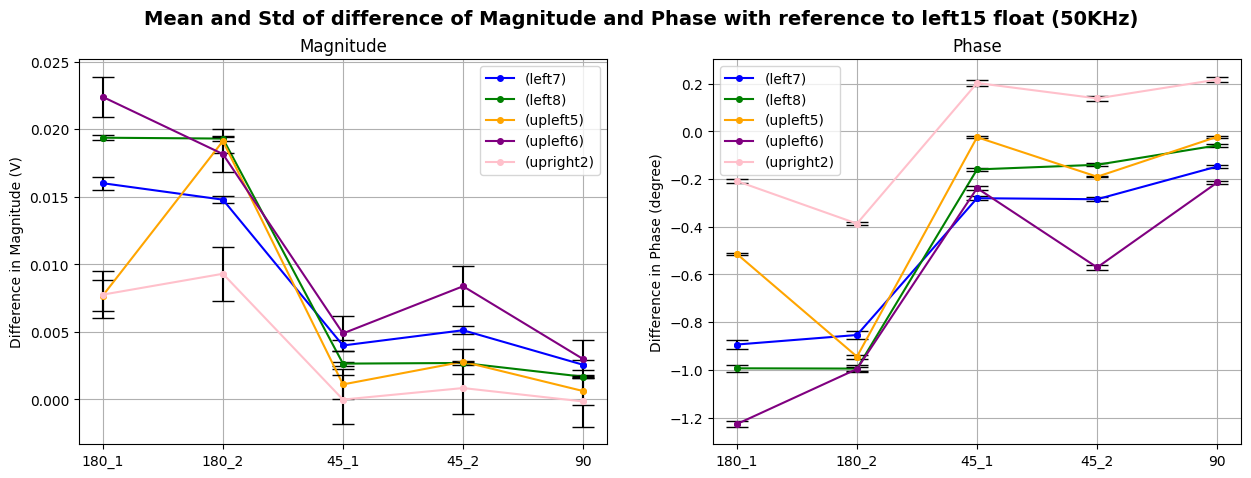

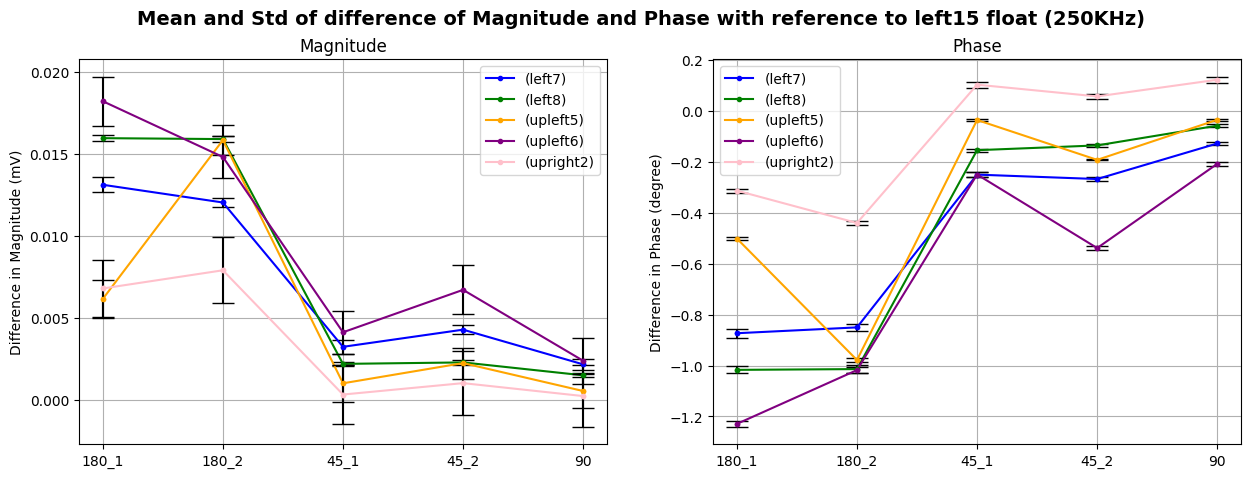

In [34]:
mean_std(ref_dict=ref_dict, data_dict=data_dict, tip = "E2")